# Tarea 3.  Cadenas de Markov y procesos de Markov (Corregida)


En esta tarea se ejercitarán los temas relacionados con las cadenas de Markov y los procesos de Markov. La tarea consiste en realizar los ejercicios incluídos en esta jupyter notebook y entregarlos completos. 

Comenzamos leyendo las diferentes librerías que se utilizarán para la tarea. Ejecute el siguiente script. 

In [2]:
%matplotlib inline

import numpy as np
import pylab as plt
import matplotlib.cm as cm
import matplotlib
from PIL import Image as im
import math
import time 
#import networkx as nx
#import pandas as pd 

import mdptoolbox
import mdptoolbox.example

from IPython.display import display
from IPython.display import Image



## Definición del problema
  
    

Considere el siguiente problema de modelado [Variante 1].

Una rata es colocada aleatoriamente en uno de los cinco compartimentos del laberinto que describe la siguiente figura. 

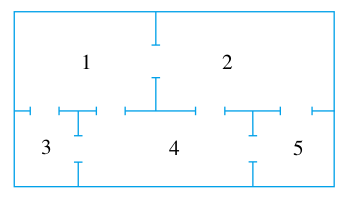

In [13]:
Image(filename='Short_Maze_Figure.png') 

La probabilidad de que la rata en el compartimento 1 se mueva al compartimento 2 es 0.3; al compartimento 3 es 0.2; y al compartimento 4 es 0.1.    

Una rata en el compartimento 2 se mueve a los compartimentos 1, 4, y 5 con probabilidades de 0.2, 0.6, y 0.1, respectivamente.    

Una rata en el compartimento 3 no puede abandonarlo.    

Una rata en el compartimento 4 se mueve a los compartimentos 1, 2, 3, y 5 con probabilidades 0.1, 0.1, 0.4, 0.3, respectivamente.   

Una rata en el compartimento 5 no puede abandonarlo. 

## Ejercicio 1

Implemente en la siguiente celda un procedimiento en python que dada una celda de origen $i$, una celda de destino $j$, y un momento en el tiempo $k$, devuelva cuál es la probabilidad de que la rata pase del compartimento $i$ al $j$ en el momento $k$. 

In [17]:
T_1 = [[0.4,0.3,0.2,0.1,  0], #matriz de transición
       [0.2,0.1,  0,0.6,0.1],
       [  0,  0,  1,  0,  0],
       [0.1,0.1,0.4,0.1,0.3],
       [  0,  0,  0,  0,  1]]

def transition_1(M, i,j):
    return M[i-1][j-1] # las celdas están indexadas desde 1, no desde 0


transition_1(T_1, 4, 3)

0.4

## Ejercicio 2

Considere una variante del problema anterior [Variante 2] en que todas las probabilidades se mantienen iguales excepto las de los compartimentos 3 y 5 que cambian de la siguiente forma.

Una rata en el compartimento 3 puede abandonarlo con probabilidad 0.5 pero solamente puede moverse al compartimento 4.

Una rata en el compartimento 5 puede abandonarlo con probabilidad 0.5 pero solamente puede moverse al compartimento 2.


Implemente en la siguiente celda un procedimiento en python que dada una distribución inicial de la probabilidad de que la rata esté en cada una de las celdas, y un valor para el instante k>0,  visualice la probabilidad de que la rata esté en cada una de las 5 celdas en el intervalo $[0,\dots,k]$.    

La salida del programa debe ser una figura con cinco curvas, cada una correspondiente a la probabilidad de estar en cada celda. 

5
Numerical evolution of transition probabilities:
[0.2, 0.2, 0.2, 0.2, 0.2]
[ 0.14  0.2   0.22  0.26  0.18]
[ 0.122  0.178  0.242  0.27   0.188]
[ 0.1114  0.1754  0.2534  0.267   0.1928]
[ 0.10634  0.17406  0.25578  0.26978  0.19404]



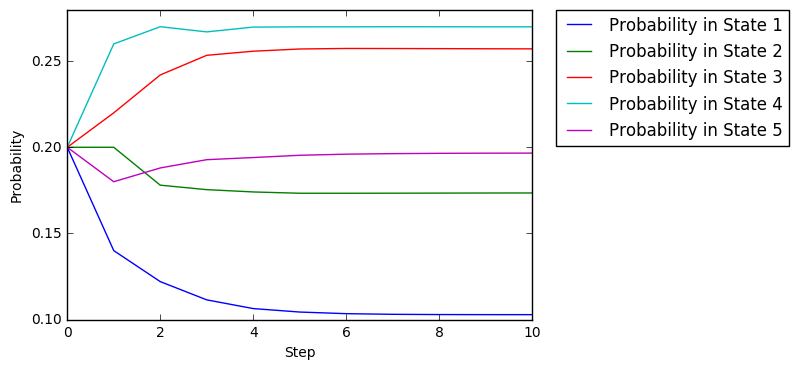

In [22]:
T_2 = [[0.4,0.3,0.2,0.1,  0],
       [0.2,0.1,  0,0.6,0.1],
       [  0,  0,0.5,0.5,  0],
       [0.1,0.1,0.4,0.1,0.3],
       [  0,0.5,  0,  0,0.5]]

def transition_2(M, i,j,k):
    return M[i-1][j-1] # las celdas están indexadas desde 1, no desde 0

def plot_probabilities(M, initial_distr, k):
    probs = []
    
    prob = initial_distr
    probs.append(prob)
    
    for i in range(k):
        prob = np.dot(prob,M)
        probs.append(prob)
    
    print("Numerical evolution of transition probabilities:")
    for i in range(len(M)):
        print(probs[i])
    print()
    
    probs_plot = np.transpose(probs)
    
    # print all the stuff
    x1 = np.array(list(range(k+1)))
    for i in range(len(probs_plot)):
        plt.plot(x1, np.array(probs_plot[i,]), label=r'Probability in State ' +str(i+1))
    plt.xlabel("Step")
    plt.ylabel("Probability")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

print(len(T_2))
plot_probabilities(T_2, [0.2,0.2,0.2,0.2,0.2], 10)



Los resultados muestran que la evolución de las probabilidades de estar en cada estado se estabilizan aproximadamente en el 4-5 paso, donde la probabilidad de estar en el compartimento 1 es la más baja y de estar en el compartimento 4 la más alta.

## Ejercicio 3

Consideramos ahora un proceso de Markov con dos posibles acciones cuyas matrices de transición son las correspondientes a las Variantes 1 y 2 descritas arriba. 
La Variante 1 podría corresponder al caso cuando las lámparas de los 5 compartimentos están encendidas y la Variante 2 al caso cuando las lámparas de todos los compartimentos están apagadas. 

Cuando todas las lámparas están encendidas la retribución (reward) obtenido por pasar del compartimento $i$ al $j$ se define como $r^1_{i,j}=j-i$. 


Cuando todas las luces están apagadas el reward se define de la siguiente forma:   
$r^2_{i,5}=-5$.    

$r^2_{i,3}= 5$.    

$r^2_{i,j}= sign(j-i)$.  Para $j \neq 3$ y $j \neq 5$.


a) Calcule la política óptima en un horizonte finito con un número de etapas $t=10$.

b) Calcule la política óptima en un horizonte infinito con un descuento $\gamma = 0.01$.


In [19]:
#define the rewards:

R_1 = np.empty([len(T_1), len(T_1)]) # just initialize the matrix, we will now change within-matrix elements
for i in range(len(R_1)):
    for j in range(len(R_1)):
        R_1[i][j] = j - i # = (j+1) - (i+1), so, we don't have to take the indexation from 1 into account 

R_2 = np.empty([len(T_1), len(T_1)]) # initialize it...
for i in range(len(R_2)):
    for j in range(len(R_2)):
        if j == 2: # j=3...
            R_2[i][j] = 5
        elif j == 4: # j=5...
            R_2[i][j] = -5
        else:
            R_2[i][j] = np.sign(j-i)

Expected rewards in each stage:
[[ 11.09942554  10.41085189   9.6565957    8.8047668    7.846177     6.77068
    5.5848       4.269        2.98         1.4          0.        ]
 [  8.65594661   8.01437666   7.38784609   6.7206275    5.966747     5.12327
    4.1665       3.165        1.89         1.3          0.        ]
 [ 12.65398386  11.99975011  11.31909765  10.546812     9.669095     8.67105
    7.526        6.225        4.65         3.           0.        ]
 [  7.93546864   7.30821762   6.68040256   6.0913833    5.424529     4.66714
    3.8161       2.827        1.8          0.3          0.        ]
 [  1.44422829   0.87407992   0.36031375   0.           0.           0.
    0.           0.           0.           0.           0.        ]]
Best policy:
[[1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 0]]


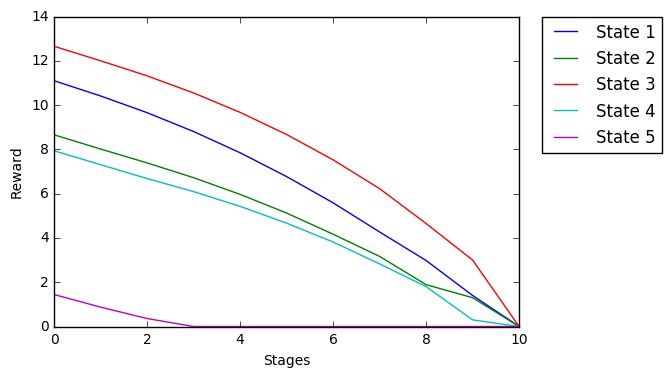

In [37]:
# a) Política óptima en un horizonte finito con un número de etapas t=10:
AllTs = np.array([T_1,T_2])
AllRs = np.array([R_1,R_2])
number_stages = 10
discount = 1
fh = mdptoolbox.mdp.FiniteHorizon(AllTs,AllRs, discount, number_stages)

fh.run()    
Vs_per_Stages = fh.V   
BestPolicy = fh.policy

print("Expected rewards in each stage:")
print(Vs_per_Stages)
print("Best policy:") 
print(BestPolicy)

x1 = np.array(list(range(number_stages+1)))
for i in range(len(T_2)):
    plt.plot(x1, np.array(Vs_per_Stages[i]), label=r'State ' +str(i+1))
plt.xlabel("Stages")
plt.ylabel("Reward")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


Los resultados muestran que a partir del instante 3 la politica óptima converge a encender la luz si se está en los estados 2 o 5, y apagarla en los estados 1, 3 y 4 (luz encendida = 0 y luz apagada = 1).

Expected rewards in each stage: 
(1.4159289000000002, 1.3060275000000001, 3.0166575, 0.31510270000000007, 0.0)
Best policy :
(1, 0, 1, 1, 0)


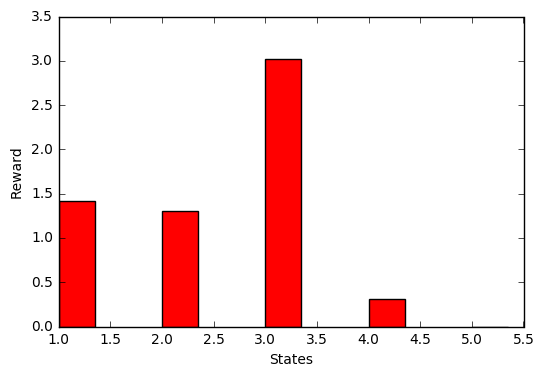

In [28]:
# b) Política óptima en un horizonte infinito con un descuento γ=0.01:

AllTs = np.array([T_1,T_2])
AllRs = np.array([R_1,R_2])
discount = 0.01
pi = mdptoolbox.mdp.PolicyIteration(AllTs, AllRs, discount=discount, eval_type="iterative")
pi.run()

Vs_per_Stages = pi.V   # Expected rewards by stages

BestPolicy = pi.policy

print("Expected rewards in each stage: ")
print(Vs_per_Stages)
print("Best policy :") 
print(BestPolicy)

# Display of the expected rewards
width = 0.35               # Width of the bars
nstates = 5               # Number of the states
ind = np.arange(nstates)   # x locations for the groups
fig, ax = plt.subplots()
rects1 = ax.bar(ind+1,Vs_per_Stages, width, color='r')
plt.ylabel(r'Reward')
plt.xlabel(r'States')
plt.show()


En caso el caso de considerar un horizonte infinito, la política óptima es la misma que en el caso anterior una vez esta había convergido: encender la luz si se está en los estados 2 o 5, y apagarla en los estados 1, 3 y 4.